# Wind farm optimisation - 2 GW of dedicated offshore wind for hydrogen production

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import mapclassify as mc
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from matplotlib_scalebar.scalebar import ScaleBar

from h2ss import capacity as cap
from h2ss import compare
from h2ss import data as rd
from h2ss import functions as fns
from h2ss import optimisation as opt

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Halite data

In [3]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

## Constraints

In [4]:
# exploration wells
_, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

# wind farms
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data", "wind-farms", "marine-area-consent-wind.zip"
    )
)

# frequent shipping routes
_, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

# shipwrecks
_, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "shipwrecks", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

# subsea cables
_, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "subsea-cables", "KIS-ORCA.gpkg"),
    dat_extent=extent,
)

In [5]:
# distance from salt formation edge
edge_buffer = fns.constraint_halite_edge(dat_xr=ds)

## Zones of interest

In [6]:
zones, zds = fns.zones_of_interest(
    dat_xr=ds,
    constraints={"net_height": 120, "min_depth": 500, "max_depth": 2000},
)

## Generate caverns

In [7]:
caverns = fns.generate_caverns_hexagonal_grid(
    zones_df=zones,
    dat_extent=extent,
)

In [8]:
caverns = fns.cavern_dataframe(
    dat_zone=zds,
    cavern_df=caverns,
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [9]:
# label caverns by depth and heights
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[120],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [10]:
caverns, _ = fns.generate_caverns_with_constraints(
    cavern_df=caverns,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 568
------------------------------------------------------------
Excluding salt formation edges...
Number of potential caverns: 539
------------------------------------------------------------
Exclude shipping...
Number of potential caverns: 261
Caverns excluded: 51.58%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 218
Caverns excluded: 59.55%
------------------------------------------------------------
Exclude cables...
Number of potential caverns: 218
Caverns excluded: 59.55%
------------------------------------------------------------
Exclude wells...
Number of potential caverns: 218
Caverns excluded: 59.55%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 218
Caverns excluded: 59.55%
------------------------------------------------------------


## Capacity

In [11]:
caverns["cavern_total_volume"] = cap.cavern_volume(
    height=caverns["cavern_height"]
)
caverns["cavern_volume"] = cap.corrected_cavern_volume(
    v_cavern=caverns["cavern_total_volume"]
)

caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(
    thickness_overburden=caverns["TopDepthSeabed"],
    depth_water=-caverns["Bathymetry"],
)

caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

(
    caverns["working_mass"],
    caverns["mass_operating_min"],
    caverns["mass_operating_max"],
) = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

## Power curve [MW] and Weibull wind speed distribution

In [12]:
# extract data for wind farms at 150 m
weibull_wf_df = fns.read_weibull_data(
    data_path_weibull=os.path.join(
        "data", "weibull-parameters-wind-speeds", "Weibull_150m_params_ITM.zip"
    ),
    data_path_wind_farms=os.path.join(
        "data", "wind-farms", "marine-area-consent-wind.zip"
    ),
)

In [13]:
weibull_powercurve = opt.weibull_distribution(weibull_wf_data=weibull_wf_df)

## Number of reference wind turbines

In [14]:
# 2 GW of offshore wind for green hydrogen production by 2030
# in addition to 5 GW offshore wind target in CLimate Action Plan 2023
# pg. 134
# assume this 2 GW is distributed evenly to the total capacity
print(
    f"{2 / 7 * 100:.2f}% of total offshore wind farm capacity dedicated "
    f"to H\N{SUBSCRIPT TWO} production"
)

28.57% of total offshore wind farm capacity dedicated to H₂ production


In [15]:
# max wind farm capacity
weibull_wf_df["cap"] = [int(x * 2 / 7) for x in [1300, 824, 500]]

In [16]:
# number of 15 MW turbines, rounded down to the nearest integer
weibull_wf_df["n_turbines"] = opt.number_of_turbines(
    owf_cap=weibull_wf_df["cap"]
)

## Annual energy production [MWh]

In [17]:
weibull_wf_df = opt.annual_energy_production(weibull_wf_data=weibull_wf_df)

## Annual hydrogen production [kg]

In [18]:
weibull_wf_df["AHP"] = opt.annual_hydrogen_production(aep=weibull_wf_df["AEP"])

## AHP as a proportion of the total working mass

In [19]:
weibull_wf_df["AHP_frac"] = (
    weibull_wf_df["AHP"] / caverns[["working_mass"]].sum().iloc[0]
)

## AHP converted to storage demand [GWh]

In [20]:
weibull_wf_df["demand"] = cap.energy_storage_capacity(
    m_working=weibull_wf_df["AHP"]
)

## Number of caverns required based on cumulative working mass and AHP

In [21]:
compare.calculate_number_of_caverns(
    cavern_df=caverns, weibull_wf_data=weibull_wf_df
)

Codling Wind Park
Working mass [kg]: 3.057689E+07
Number of caverns required: 7–17
Capacity (approx.) [GWh]: 1,087.05
------------------------------------------------------------------------------
Dublin Array
Working mass [kg]: 1.872921E+07
Number of caverns required: 4–11
Capacity (approx.) [GWh]: 656.97
------------------------------------------------------------------------------
North Irish Sea Array
Working mass [kg]: 1.231565E+07
Number of caverns required: 3–7
Capacity (approx.) [GWh]: 471.43
------------------------------------------------------------------------------
Total number of caverns required: 14–35
------------------------------------------------------------------------------
Number of caverns required as a percentage of all available caverns:
6.42–16.06%
------------------------------------------------------------------------------
Total maximum cavern capacity (approx.): 2,215.45 GWh


## Transmission distance [km]

In [22]:
caverns, injection_point = opt.transmission_distance(
    cavern_df=caverns, wf_data=wind_farms
)

## Electrolyser capacity [MW]

In [23]:
weibull_wf_df["E_cap"] = opt.electrolyser_capacity(
    n_turbines=weibull_wf_df["n_turbines"]
)

## CAPEX for pipeline [€ km⁻¹]

In [24]:
weibull_wf_df["CAPEX"] = opt.capex_pipeline(e_cap=weibull_wf_df["E_cap"])

In [25]:
weibull_wf_df

,name,cap,"(c, min)","(c, max)","(c, mean)","(k, min)","(k, max)","(k, mean)",n_turbines,AEP,integral,abserr,AHP,AHP_frac,demand,E_cap,CAPEX
0,Codling Wind Park,371,10.2,10.8,10.500000,1.9,2.0,1.950000,24,1.548908e+06,8.335975,2.528685e-07,3.057689e+07,0.043023,1018.889987,298,953350.780836
1,Dublin Array,235,9.9,10.6,10.292857,1.9,2.0,1.950000,15,9.487500e+05,8.169630,3.778893e-07,1.872921e+07,0.026353,624.098782,186,868435.651965
2,North Irish Sea Array,142,10.7,11.2,10.950000,2.1,2.2,2.133333,9,6.238637e+05,8.953423,1.516351e-07,1.231565e+07,0.017329,410.384794,112,806313.935209


In [26]:
# totals
weibull_wf_df[
    ["cap", "n_turbines", "AEP", "AHP", "AHP_frac", "demand", "E_cap", "CAPEX"]
].sum()

cap           7.480000e+02
n_turbines    4.800000e+01
AEP           3.121522e+06
AHP           6.162175e+07
AHP_frac      8.670528e-02
demand        2.053374e+03
E_cap         5.960000e+02
CAPEX         2.628100e+06
dtype: float64

In [27]:
compare.electricity_demand_ie(data=weibull_wf_df["demand"])

Energy capacity as a percentage of Ireland's electricity demand
in 2050 (84–122 TWh electricity), assuming a conversion efficiency
of 50%: 0.84–1.22%
Energy capacity as a percentage of Ireland's hydrogen demand
in 2050, assuming it is 17% of the electricity demand
(84–122 TWh electricity): 9.90–14.38%


In [28]:
compare.hydrogen_demand_ie(data=weibull_wf_df["demand"])

Energy capacity as a percentage of Ireland's domestic hydrogen
demand in 2050 (4.6–39 TWh hydrogen): 5.27–44.64%
Energy capacity as a percentage of Ireland's domestic and
non-domestic hydrogen demand in 2050 (19.8–74.6 TWh hydrogen): 2.75–10.37%


## LCOT for pipeline [€ kg⁻¹]

In [29]:
caverns = opt.lcot_pipeline(weibull_wf_data=weibull_wf_df, cavern_df=caverns)

In [30]:
caverns[
    [
        "cavern_depth",
        "working_mass",
        "capacity",
        "distance_ip",
    ]
    + list(caverns.filter(like="dist_"))
    + list(caverns.filter(like="LCOT_"))
].describe()

,cavern_depth,working_mass,capacity,distance_ip,dist_Codling_Wind_Park,dist_Dublin_Array,dist_North_Irish_Sea_Array,LCOT_Codling_Wind_Park,LCOT_Dublin_Array,LCOT_North_Irish_Sea_Array
count,218.000000,2.180000e+02,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000
mean,1154.020877,3.260108e+06,108.634041,29.197826,58.408245,43.581633,44.393167,0.149190,0.165785,0.238420
std,365.142804,7.786651e+05,25.946851,6.830597,11.452952,13.055932,7.523248,0.029132,0.049387,0.040183
min,502.745339,1.678950e+06,55.946359,16.263066,33.027322,17.542931,32.980512,0.084632,0.067288,0.177463
25%,872.651330,2.685380e+06,89.482842,23.216441,51.592318,33.503367,36.808911,0.131853,0.127662,0.197911
50%,1128.329146,3.277441e+06,109.211632,30.947028,58.988376,47.378240,44.619590,0.150666,0.180147,0.239629
75%,1433.385847,3.886101e+06,129.493525,34.863247,67.109072,54.107289,50.773606,0.171322,0.205601,0.272499
max,1980.680682,4.765555e+06,158.798899,42.990158,80.806729,70.176200,67.926218,0.206163,0.266386,0.364114


In [31]:
pd.Series(caverns[list(caverns.filter(like="dist_"))].values.flat).describe()

count    654.000000
mean      48.794348
std       12.862247
min       17.542931
25%       36.924385
50%       49.890968
75%       57.488679
max       80.806729
dtype: float64

In [32]:
pd.Series(caverns[list(caverns.filter(like="LCOT_"))].values.flat).describe()

count    654.000000
mean       0.184465
std        0.055972
min        0.067288
25%        0.139294
50%        0.184327
75%        0.225437
max        0.364114
dtype: float64

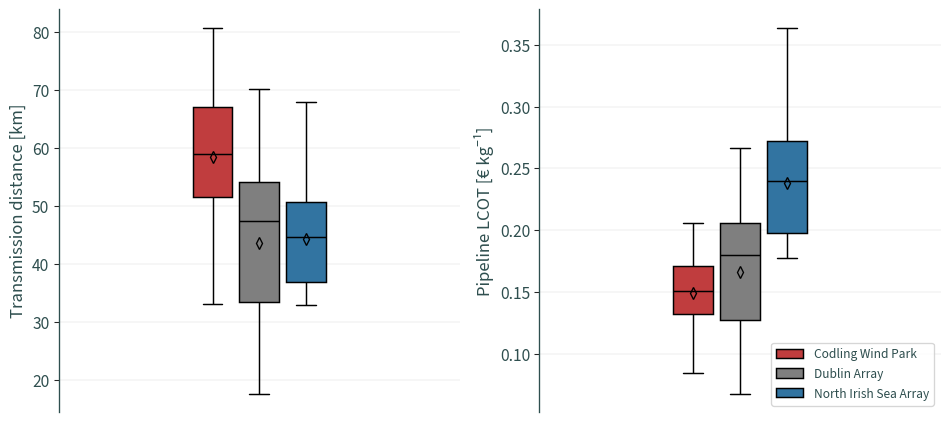

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))
for n, col, lab, show_legend in zip(
    [0, 1],
    ["dist_", "LCOT_"],
    ["Transmission distance [km]", "Pipeline LCOT [€ kg⁻¹]"],
    [False, True],
):
    sns.boxplot(
        caverns.filter(like=col)
        .set_axis(list(wind_farms["name"]), axis=1)
        .melt(),
        y="value",
        hue="variable",
        palette=sns.color_palette(["tab:red", "tab:gray", "tab:blue"]),
        width=0.35,
        ax=axes[n],
        legend=show_legend,
        linecolor="black",
        linewidth=1.1,
        gap=0.15,
        showmeans=True,
        meanprops={
            "marker": "d",
            "markeredgecolor": "black",
            "markerfacecolor": "none",
        },
    )
    axes[n].set_ylabel(lab)
    axes[n].tick_params(axis="x", bottom=False)
    axes[n].yaxis.grid(True, linewidth=0.25)
axes[1].legend(loc="lower right")
sns.despine(bottom=True)
plt.tight_layout()
plt.show()

## Maps

In [34]:
shape = rd.halite_shape(dat_xr=ds).buffer(1000).buffer(-1000)

In [35]:
def plot_map_facet(
    cavern_df,
    classes,
    fontsize=11.5,
):
    """Helper function for plotting LCOT facet maps"""
    fig1 = plt.figure(figsize=(11, 11.75))
    xmin_, ymin_, xmax_, ymax_ = cavern_df.total_bounds
    colours = [int(n * 255 / (len(classes) - 1)) for n in range(len(classes))]
    legend_handles = []
    classes = sorted(classes)

    for n1, c in enumerate(colours):
        if n1 == 0:
            label = f"< {classes[n1]:.2f}"
        elif n1 == len(colours) - 1:
            label = f"≥ {classes[-2]:.2f}"
        else:
            label = f"{classes[n1 - 1]:.2f} – < {classes[n1]:.2f}"
        legend_handles.append(
            mpatches.Patch(
                facecolor=sns.color_palette("flare", 256)[c], label=label
            )
        )

    for a, wf1 in enumerate(list(wind_farms["name"])):
        ax1 = fig1.add_subplot(2, 2, a + 1, projection=ccrs.epsg(rd.CRS))
        gpd.GeoDataFrame(cavern_df, geometry=cavern_df.centroid).plot(
            ax=ax1,
            scheme="UserDefined",
            classification_kwds={"bins": classes},
            column=f"LCOT_{wf1.replace(' ', '_')}",
            zorder=2,
            marker=".",
            cmap="flare",
            markersize=20,
        )
        shape.plot(
            ax=ax1, color="white", alpha=0.5, edgecolor="slategrey", zorder=1
        )
        cx.add_basemap(
            ax1,
            crs=rd.CRS,
            source=cx.providers.CartoDB.VoyagerNoLabels,
            attribution=False,
        )
        ax1.gridlines(
            draw_labels={"bottom": "x"},
            color="lightslategrey",
            alpha=0.25,
            xlabel_style={"fontsize": fontsize},
            xformatter=LongitudeFormatter(auto_hide=False, dms=True),
        )
        if not a == 1:
            ax1.gridlines(
                draw_labels={"left": "y"},
                color="lightslategrey",
                alpha=0.25,
                ylabel_style={"fontsize": fontsize, "rotation": 89.9},
                yformatter=LatitudeFormatter(auto_hide=False, dms=True),
            )
        if a == 2:
            ax1.add_artist(
                ScaleBar(
                    1,
                    box_alpha=0,
                    location="lower right",
                    color="darkslategrey",
                    font_properties={"size": fontsize},
                )
            )
            plt.legend(
                loc="lower right",
                bbox_to_anchor=(1, 0.075),
                handles=legend_handles,
                title="Pipeline LCOT [€ kg⁻¹]",
                fontsize=fontsize,
                title_fontsize=fontsize,
            )
        plt.xlim(xmin_ - 1000, xmax_ + 1000)
        plt.ylim(ymin_ - 1000, ymax_ + 1000)
        ax1.set_title(list(wind_farms["name"])[a])

    plt.tight_layout()
    # plt.savefig(
    #     os.path.join("graphics", "fig_map_transmission_2gw.jpg"),
    #     format="jpg", dpi=600
    # )
    plt.show()

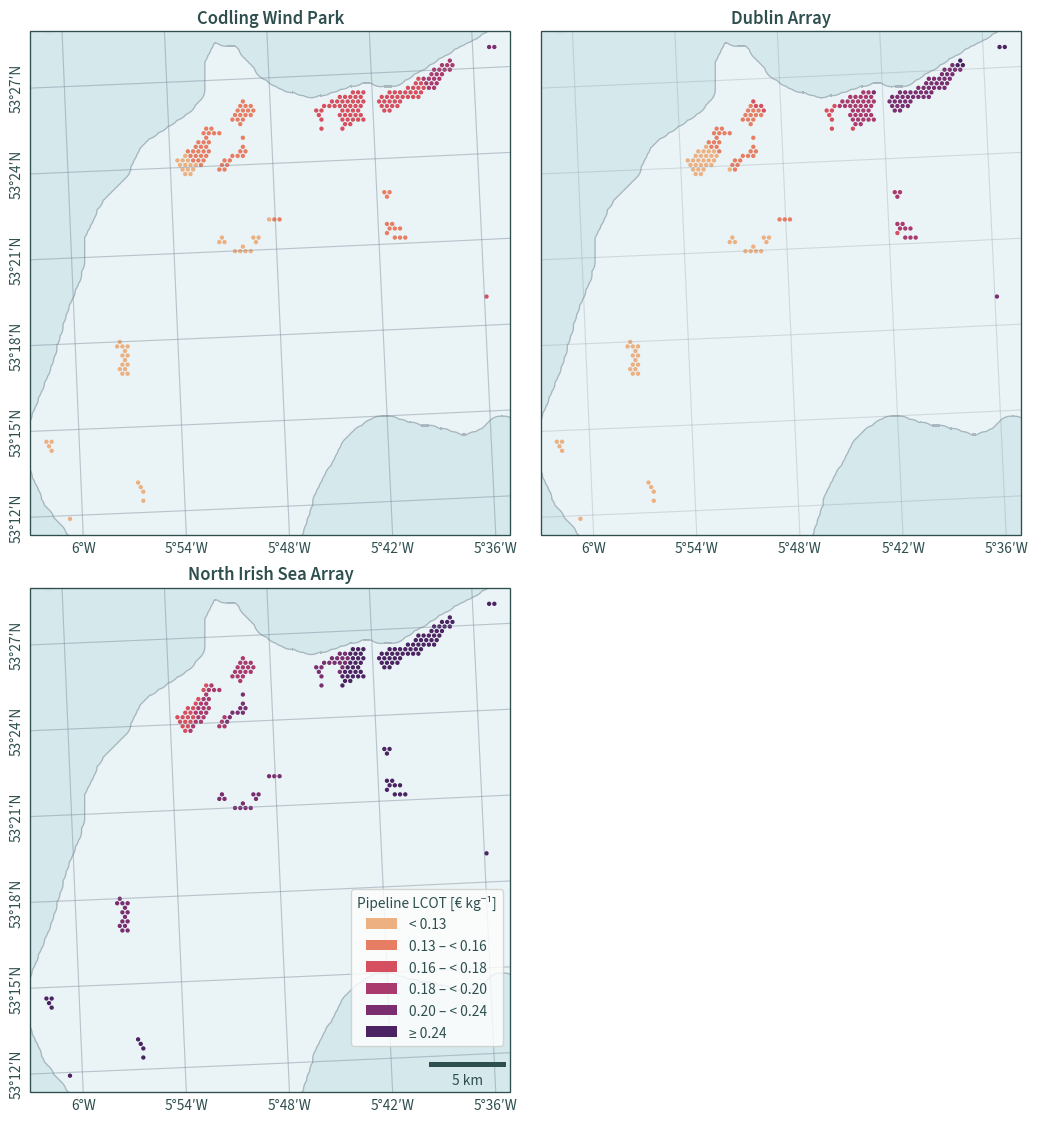

In [36]:
plot_map_facet(
    caverns,
    list(mc.Quantiles(caverns[list(caverns.filter(like="LCOT_"))], k=6).bins),
)